In [1]:
import logging
from pathlib import Path
import sys
import data_loading
import utils
import explainers
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings


In [2]:
logging.basicConfig(format='%(asctime)s %(levelname)-7s %(message)s',
                    stream=sys.stderr, level=logging.DEBUG)
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [3]:
DATASET_NAME = 'cstr2'
WINDOW_SIZE = 20

In [4]:
# exclude_columns = ['Fault']

In [5]:
timeseries, labels, test_timeseries, test_labels = \
        data_loading.get_dataset(DATASET_NAME, binary=False, window_size=WINDOW_SIZE, noise_scale=0.001, use_classes=list(range(0,10)))

In [6]:
# print(timeseries)
# print(labels.head)
print(test_timeseries)
# print(labels['label'])

                          Caf         h          Qf        Ca           T  \
node_id   timestamp                                                         
node_1_20 1          1.000343  6.003653  100.036447  0.037208  401.664793   
          2          0.999223  6.008526   99.972154  0.037228  402.253245   
          3          0.999419  5.986206   99.864738  0.037281  402.460461   
          4          1.000432  5.994810   99.806699  0.037239  402.545277   
          5          0.998415  5.998917   99.950405  0.037165  401.758332   
...                       ...       ...         ...       ...         ...   
node_9_99 95         1.000708  6.000964  100.048414  0.052748  395.545498   
          96         0.999586  6.015635   99.793009  0.052809  395.669699   
          97         0.999569  5.999759  100.190331  0.052735  396.206936   
          98         1.001832  5.998544  100.033790  0.052777  395.945232   
          99         1.000035  5.998387   99.840257  0.052740  395.615456   

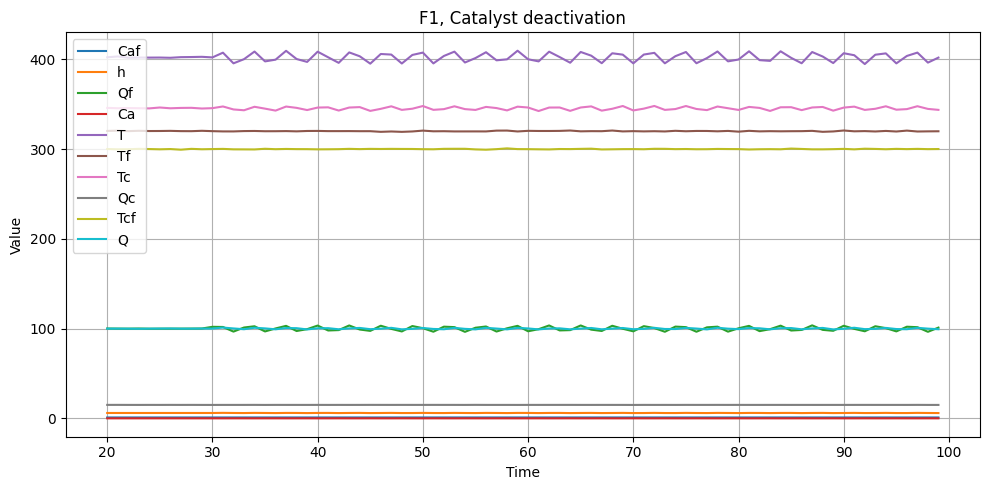

In [7]:
comparison_df=pd.DataFrame(test_timeseries)
comparison_df = comparison_df.groupby(level='node_id').last()
comparison_df['ind_node'] = ([int(element.split('_')[1]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df['ind_time'] = ([int(element.split('_')[2]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df.set_index(['ind_node', 'ind_time'], inplace=True)
label_dict = {'1': 'F1, Catalyst deactivation', '2': 'F2, Heat-exchanger fouling', '3': 'F3, Dead-coolant flow measurement', '4': 'F4, Bias in reactor temperature measurement', '5': 'F5, Coolant valve stiction qF7', '6': 'F6, Step change in QF', '7': 'F7, Ramp change in CAF', '8': 'F8, Ramp change in TF', '9': 'F9, Ramp change in TCF', '0': 'N, Normal operation'}

for i in range(1,2):
    single_node_df = comparison_df.loc[comparison_df.index.get_level_values('ind_node') == i]
    single_node_df = single_node_df.reset_index(level='ind_node', drop=True)
    single_node_df = single_node_df.sort_index()
    
    single_node_df_filtered = single_node_df

    # columns_to_plot = ['Ca']
    # single_node_df_filtered = single_node_df[columns_to_plot]    

    # scaler = MinMaxScaler()
    # single_node_df_filtered = pd.DataFrame(scaler.fit_transform(single_node_df_filtered), columns=single_node_df_filtered.columns, index=single_node_df_filtered.index)    
    
    # print(single_node_df_filtered)

    single_node_df_filtered.plot(figsize=(10, 5))
    
    plt.title(label_dict[str(i)])
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend(loc='upper left')
    # plt.ticklabel_format(style='sci', axis='y', scilimits=(100,200))
    # plt.yticks(np.arange(0, 500, step=10))
    # plt.xticks(np.arange(WINDOW_SIZE, len(single_node_df_filtered), step=1), rotation=45)
    # plt.xlim(single_node_df_filtered.index[5], single_node_df_filtered.index[45])
    plt.tight_layout()
    plt.show()


In [8]:
extractor = utils.TSFeatureGenerator(threads=1, trim=0)
pipeline = Pipeline([
    ('assert1', utils.CheckFeatures()),
    ('features', utils.TSFeatureGenerator(threads=1, trim=0)),
    ('assert2', utils.CheckFeatures()),
    ('scaler', MinMaxScaler(feature_range=(-1, 1))),
    ('clf', RandomForestClassifier(n_estimators=100))
], verbose=True)

In [9]:
pipeline.fit(timeseries, labels)

[Pipeline] ........... (step 1 of 5) Processing assert1, total=   0.0s
[Pipeline] .......... (step 2 of 5) Processing features, total=   3.8s
[Pipeline] ........... (step 3 of 5) Processing assert2, total=   0.0s
[Pipeline] ............ (step 4 of 5) Processing scaler, total=   0.0s


/Users/omkar/anaconda3/envs/comte1/lib/python3.9/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[Pipeline] ............... (step 5 of 5) Processing clf, total=   0.2s


Pipeline(steps=[('assert1', CheckFeatures()),
                ('features', TSFeatureGenerator(threads=1, trim=0)),
                ('assert2', CheckFeatures()),
                ('scaler', MinMaxScaler(feature_range=(-1, 1))),
                ('clf', RandomForestClassifier())],
         verbose=True)

In [10]:
preds = pipeline.predict(test_timeseries)

In [11]:
print("F1 score:", f1_score(test_labels, preds, average='weighted'))
for label, i in zip(np.unique(test_labels), f1_score(test_labels, preds, labels=np.unique(test_labels), average=None)):
    print(label, i)

F1 score: 0.7121216851461545
0 0.4143222506393862
1 0.8780487804878049
2 0.8034188034188035
3 0.8103448275862069
4 0.8
5 0.7966101694915254
6 0.275
7 0.8135593220338984
8 0.7478260869565218
9 0.9115646258503401


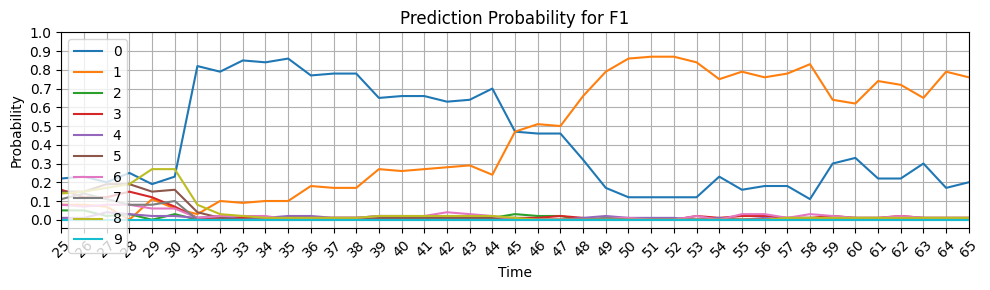

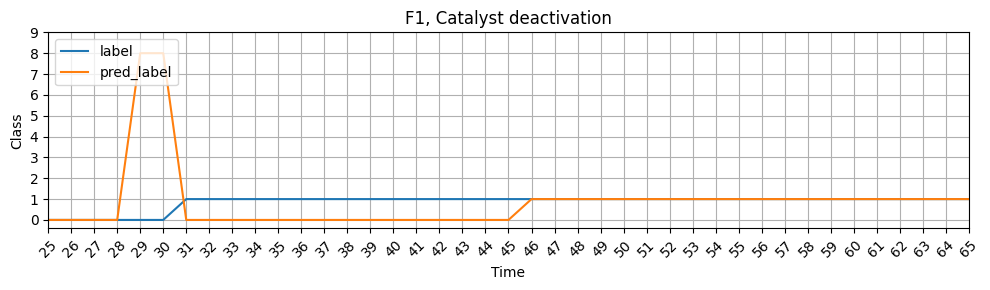

In [12]:
comparison_df=pd.DataFrame(test_labels)
comparison_df['pred_label'] = preds
comparison_df['ind_node'] = ([int(element.split('_')[1]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df['ind_time'] = ([int(element.split('_')[2]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df.set_index(['ind_node', 'ind_time'], inplace=True)
label_dict = {'1': 'F1, Catalyst deactivation', '2': 'F2, Heat-exchanger fouling', '3': 'F3, Dead-coolant flow measurement', '4': 'F4, Bias in reactor temperature measurement', '5': 'F5, Coolant valve stiction qF7', '6': 'F6, Step change in QF', '7': 'F7, Ramp change in CAF', '8': 'F8, Ramp change in TF', '9': 'F9, Ramp change in TCF', '0': 'N, Normal operation'}

warnings.filterwarnings("ignore")

for i in range(1,2):
    # print(comparison_df)
    single_node_df = comparison_df.loc[comparison_df.index.get_level_values('ind_node') == i]
    single_node_df = single_node_df.reset_index(level='ind_node', drop=True)
    single_node_df = single_node_df.sort_index()

    # print(single_node_df)
    # plt.figure(figsize=(20, 2))


# Plot prediction probability
    pred_ar = []
    for j in range(WINDOW_SIZE,100):
        loca = "node_{}_{}".format(i,j)
        predi = pipeline.predict_proba(test_timeseries.loc[[loca], :, :])
        pred_ar.append(predi[0])
    pred_df = pd.DataFrame(pred_ar, index=range(WINDOW_SIZE,100))
    # print(pred_df)

    pred_df.plot(figsize=(10, 3))
    plt.title("Prediction Probability for F{}".format(i))
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.xticks(np.arange(WINDOW_SIZE, len(single_node_df), step=1), rotation=45)
    plt.xlim(single_node_df.index[5], single_node_df.index[45])
    plt.tight_layout()
    plt.show()


    single_node_df.plot(figsize=(10, 3))

    plt.title(label_dict[str(i)])
    plt.xlabel('Time')
    plt.ylabel('Class')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.yticks(np.arange(0, 10, step=1))
    plt.xticks(np.arange(WINDOW_SIZE, len(single_node_df), step=1), rotation=45)
    plt.xlim(single_node_df.index[5], single_node_df.index[45])
    plt.tight_layout()
    plt.show()

warnings.resetwarnings()


In [13]:
comte = explainers.BruteForceSearch(pipeline, timeseries, labels, silent=False, threads=1,num_distractors=2)

In [14]:
### TEST CASE 1
### True: 2 All clear, Predicted: 3 Not clear

true_select = 1 #UPDATE HERE FOR OTHER CLASSES
pred_select = 1 #UPDATE HERE FOR OTHER CLASSES
# print(test_labels['label'].values)
# print(preds)
indices_test = []
for idx, (true, pred, node_id) in enumerate(zip(test_labels['label'].values, preds, test_labels['label'].index.get_level_values('node_id'))):
    # if(true!=pred):
    #     print(idx,true,pred)
    if true ==  true_select and pred == pred_select:
        indices_test.append([node_id,idx])
print(indices_test)


[['node_1_46', 26], ['node_1_47', 27], ['node_1_48', 28], ['node_1_49', 29], ['node_1_50', 30], ['node_1_51', 31], ['node_1_52', 32], ['node_1_53', 33], ['node_1_54', 34], ['node_1_55', 35], ['node_1_56', 36], ['node_1_57', 37], ['node_1_58', 38], ['node_1_59', 39], ['node_1_60', 40], ['node_1_61', 41], ['node_1_62', 42], ['node_1_63', 43], ['node_1_64', 44], ['node_1_65', 45], ['node_1_66', 46], ['node_1_67', 47], ['node_1_68', 48], ['node_1_69', 49], ['node_1_70', 50], ['node_1_71', 51], ['node_1_72', 52], ['node_1_73', 53], ['node_1_74', 54], ['node_1_75', 55], ['node_1_76', 56], ['node_1_77', 57], ['node_1_78', 58], ['node_1_79', 59], ['node_1_80', 60], ['node_1_81', 61], ['node_1_82', 62], ['node_1_83', 63], ['node_1_84', 64], ['node_1_85', 65], ['node_1_86', 66], ['node_1_87', 67], ['node_1_88', 68], ['node_1_89', 69], ['node_1_90', 70], ['node_1_91', 71], ['node_1_92', 72], ['node_1_93', 73], ['node_1_94', 74], ['node_1_95', 75], ['node_1_96', 76], ['node_1_97', 77], ['node_1_98

In [15]:
# timeseries.loc[['node_101_32'], :, :]

2024-03-12 15:27:55,046 INFO    Working on turning label from 1 to 0


2024-03-12 15:27:59,059 INFO    Finished constructing per class kdtree
2024-03-12 15:27:59,060 INFO    Returning distractors ['node_107_36', 'node_107_33']
2024-03-12 15:27:59,061 INFO    Trying distractor 1 / 2
2024-03-12 15:27:59,070 INFO    Current probas: [[0.12 0.86 0.   0.   0.01 0.   0.01 0.   0.   0.  ]]
2024-03-12 15:27:59,146 INFO    Best column: h, best case: 0.3
2024-03-12 15:27:59,159 INFO    Current probas: [[0.3  0.6  0.02 0.   0.01 0.   0.07 0.   0.   0.  ]]
2024-03-12 15:27:59,224 INFO    Best column: T, best case: 0.42
2024-03-12 15:27:59,237 INFO    Current probas: [[0.42 0.4  0.02 0.01 0.08 0.   0.04 0.01 0.02 0.  ]]
2024-03-12 15:27:59,237 INFO    Trying distractor 2 / 2
2024-03-12 15:27:59,246 INFO    Current probas: [[0.12 0.86 0.   0.   0.01 0.   0.01 0.   0.   0.  ]]
2024-03-12 15:27:59,322 INFO    Best column: h, best case: 0.3
2024-03-12 15:27:59,336 INFO    Current probas: [[0.3  0.6  0.02 0.   0.01 0.   0.07 0.   0.   0.  ]]
2024-03-12 15:27:59,402 INFO    

###########
['h', 'T']
###########


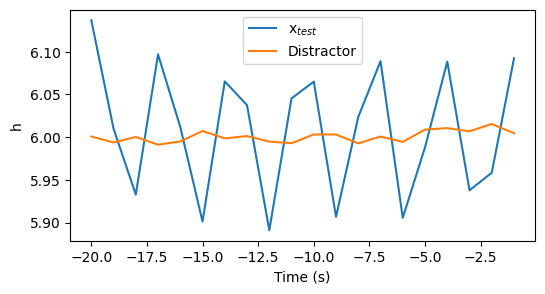

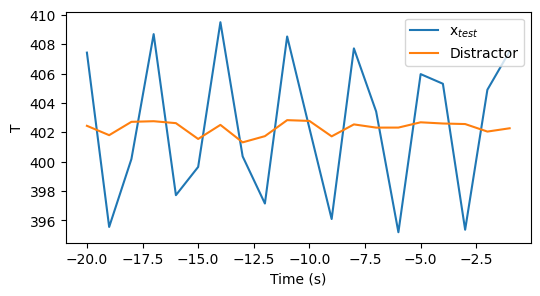

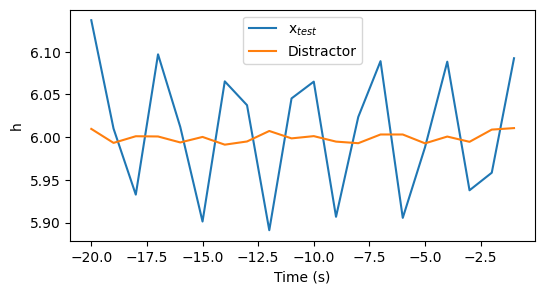

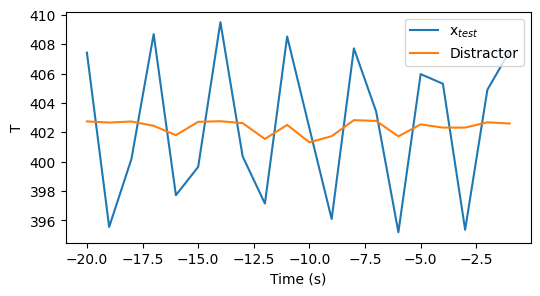

In [18]:
warnings.filterwarnings("ignore")

x_test = test_timeseries.loc[['node_1_50'], :, :]
explanation = comte.explain(x_test,to_maximize=0,savefig=False) 
print('###########') 
print(explanation)
print('###########')

warnings.resetwarnings()

2024-03-12 15:28:04,497 INFO    Working on turning label from 1 to 0
2024-03-12 15:28:04,501 INFO    Min dist:6.2948811929516415 Min dist node:node_101_20
2024-03-12 15:28:04,501 INFO    Min dist:5.532515138902342 Min dist node:node_101_21


2024-03-12 15:28:04,506 INFO    Min dist:5.520895803138642 Min dist node:node_101_32
2024-03-12 15:28:04,514 INFO    Min dist:4.943213405873191 Min dist node:node_102_32
2024-03-12 15:28:04,564 INFO    Returning distractors ['node_102_32']


###########
['h', 'T']
###########


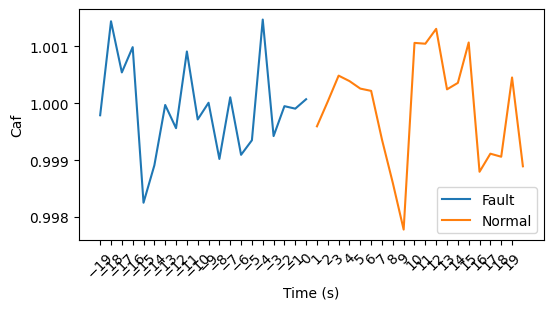

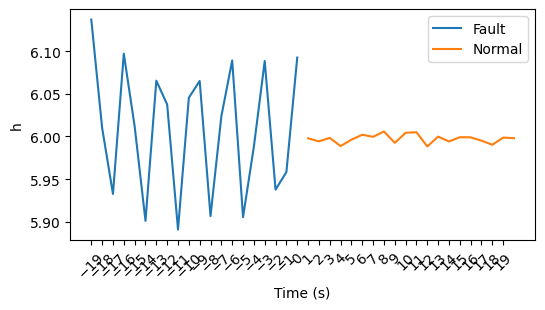

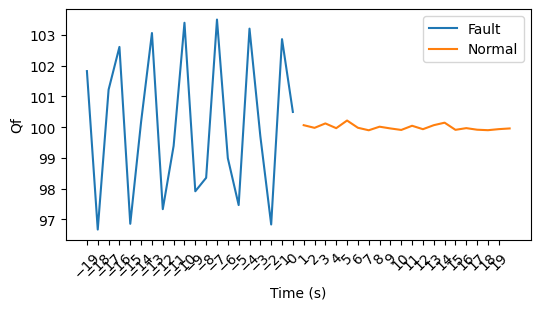

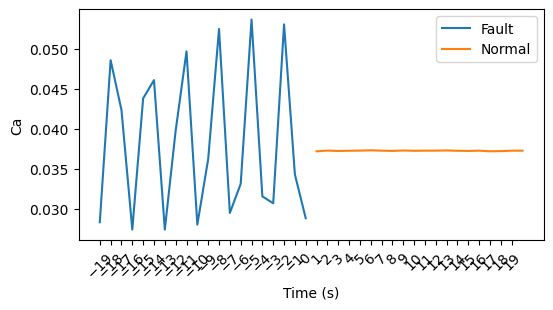

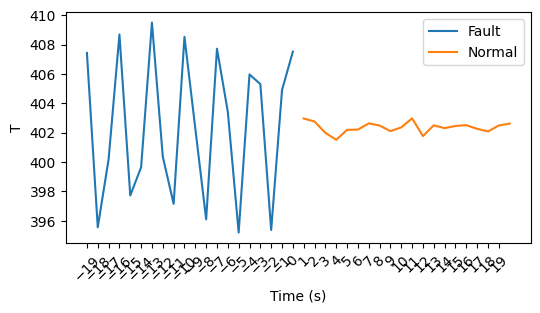

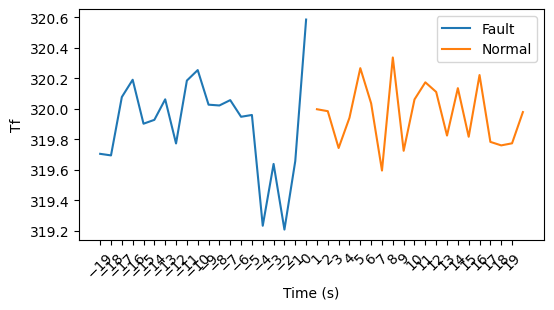

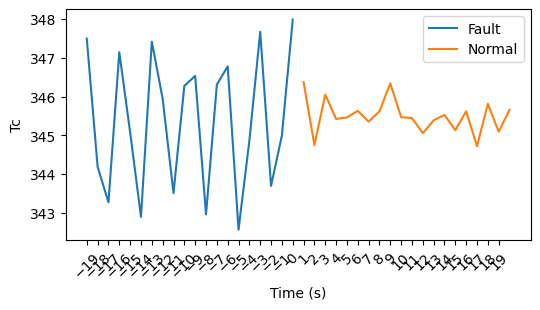

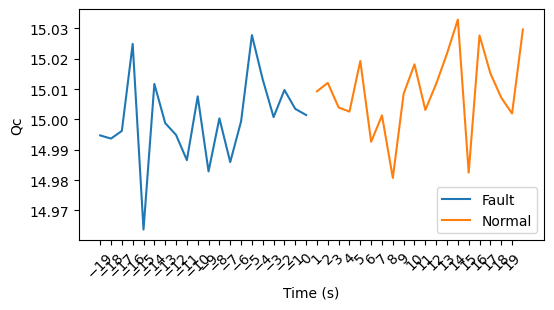

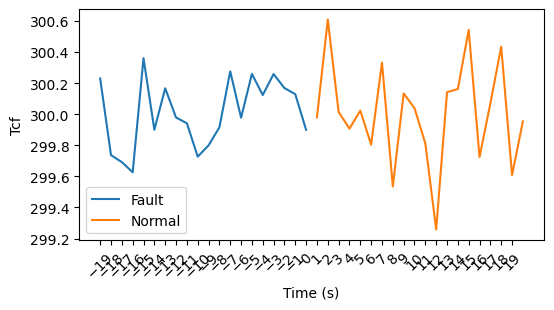

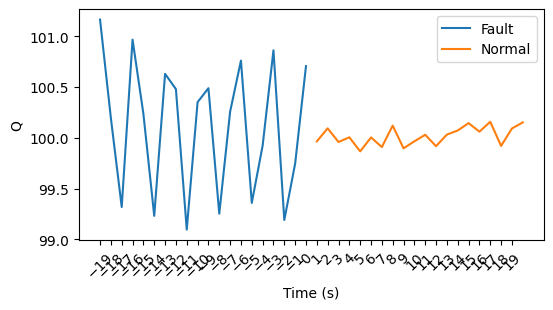

In [19]:
warnings.filterwarnings("ignore")

x_test = test_timeseries.loc[['node_1_50'], :, :]
proto_ts, proto_labels = comte.get_prototype(x_test,to_maximize=0,savefig=False) 
print('###########') 
print(explanation)
print('###########')

warnings.resetwarnings()

In [20]:
proto_preds = pipeline.predict(proto_ts)
# proto_preds
# proto_ts
# # 3 9 15

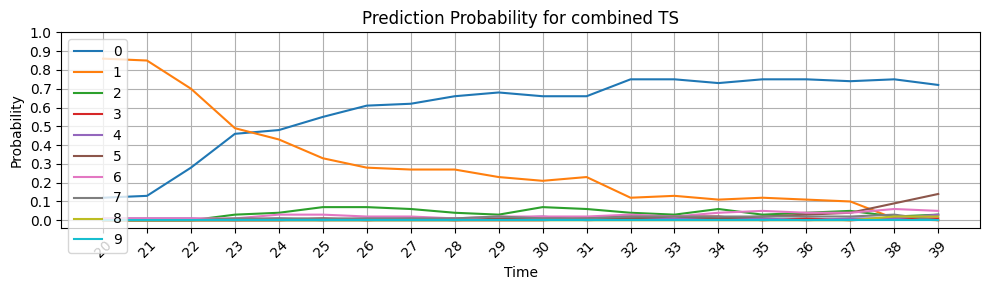

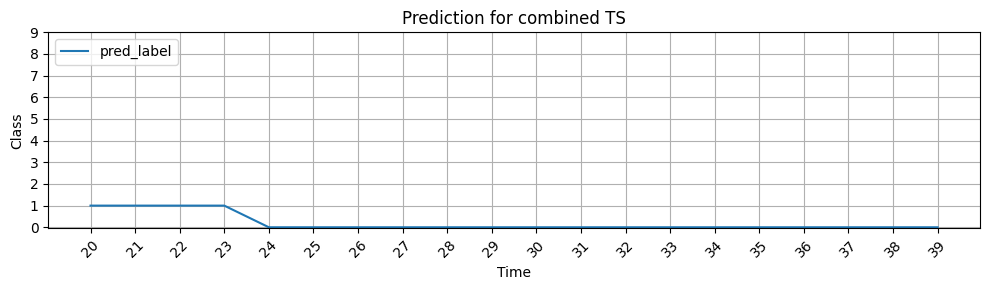

In [21]:
comparison_df=pd.DataFrame(proto_labels)
comparison_df['pred_label'] = proto_preds
comparison_df['ind_node'] = ([int(element.split('_')[1]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df['ind_time'] = ([int(element.split('_')[2]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df.set_index(['ind_node', 'ind_time'], inplace=True)
comparison_df.drop(columns=['label'], inplace=True)

label_dict = {'1': 'F1, Catalyst deactivation', '2': 'F2, Heat-exchanger fouling', '3': 'F3, Dead-coolant flow measurement', '4': 'F4, Bias in reactor temperature measurement', '5': 'F5, Coolant valve stiction qF7', '6': 'F6, Step change in QF', '7': 'F7, Ramp change in CAF', '8': 'F8, Ramp change in TF', '9': 'F9, Ramp change in TCF', '0': 'N, Normal operation'}

warnings.filterwarnings("ignore")

for i in range(1,2):
    # print(comparison_df)
    single_node_df = comparison_df.loc[comparison_df.index.get_level_values('ind_node') == i]
    single_node_df = single_node_df.reset_index(level='ind_node', drop=True)
    single_node_df = single_node_df.sort_index()

    # print(single_node_df)
    # plt.figure(figsize=(20, 2))


# Plot prediction probability
    pred_ar = []
    for j in range(WINDOW_SIZE,WINDOW_SIZE*2):
        loca = "node_{}_{}".format(i,j)
        predi = pipeline.predict_proba(proto_ts.loc[[loca], :, :])
        pred_ar.append(predi[0])
    pred_df = pd.DataFrame(pred_ar, index=range(WINDOW_SIZE,WINDOW_SIZE*2))
    # print(pred_df)

    pred_df.plot(figsize=(10, 3))
    plt.title("Prediction Probability for combined TS")
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.xticks(np.arange(WINDOW_SIZE, WINDOW_SIZE*2, step=1), rotation=45)
    plt.tight_layout()
    plt.show()


    single_node_df.plot(figsize=(10, 3))

    plt.title("Prediction for combined TS")
    plt.xlabel('Time')
    plt.ylabel('Class')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.yticks(np.arange(0, 10, step=1))
    plt.xticks(np.arange(WINDOW_SIZE, WINDOW_SIZE*2, step=1), rotation=45)
    plt.tight_layout()
    plt.show()

warnings.resetwarnings()


In [22]:
# proto_ts.loc[['node_1_10'], :, :]
# # pipeline.predict_proba(proto_ts.loc[['node_1_10'], :, :])
# test_timeseries.loc[['node_1_33'], :, :]
# timeseries.loc[['node_101_30'], :, :]

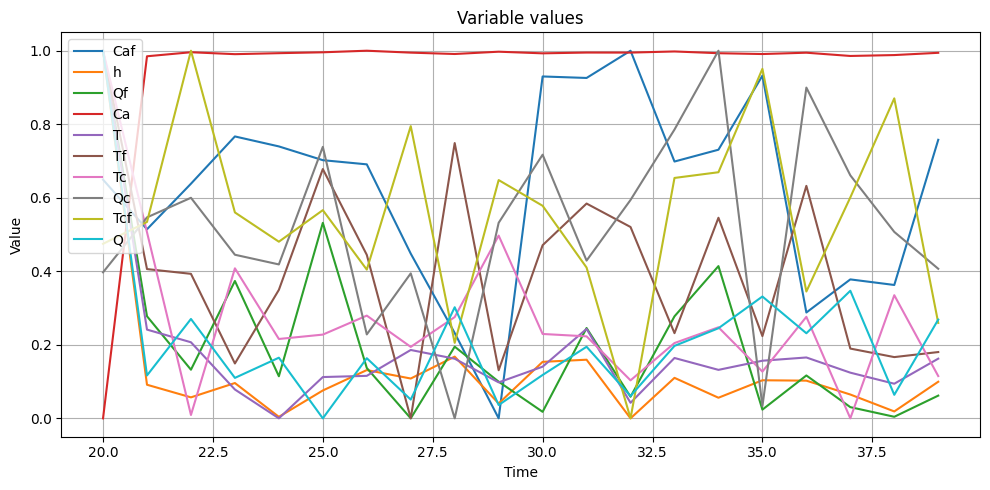

In [23]:
comparison_df=pd.DataFrame(proto_ts)
comparison_df = comparison_df.groupby(level='node_id').last()
comparison_df['ind_node'] = ([int(element.split('_')[1]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df['ind_time'] = ([int(element.split('_')[2]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df.set_index(['ind_node', 'ind_time'], inplace=True)
label_dict = {'1': 'F1, Catalyst deactivation', '2': 'F2, Heat-exchanger fouling', '3': 'F3, Dead-coolant flow measurement', '4': 'F4, Bias in reactor temperature measurement', '5': 'F5, Coolant valve stiction qF7', '6': 'F6, Step change in QF', '7': 'F7, Ramp change in CAF', '8': 'F8, Ramp change in TF', '9': 'F9, Ramp change in TCF', '0': 'N, Normal operation'}

for i in range(1,2):
    single_node_df = comparison_df.loc[comparison_df.index.get_level_values('ind_node') == i]
    single_node_df = single_node_df.reset_index(level='ind_node', drop=True)
    single_node_df = single_node_df.sort_index()
    
    single_node_df_filtered = single_node_df

    # columns_to_plot = ['Ca']
    # single_node_df_filtered = single_node_df[columns_to_plot]    

    scaler = MinMaxScaler()
    single_node_df_filtered = pd.DataFrame(scaler.fit_transform(single_node_df_filtered), columns=single_node_df_filtered.columns, index=single_node_df_filtered.index)    
    
    # print(single_node_df_filtered)

    single_node_df_filtered.plot(figsize=(10, 5))
    
    plt.title('Variable values')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend(loc='upper left')
    # plt.ticklabel_format(style='sci', axis='y', scilimits=(100,200))
    # plt.yticks(np.arange(0, 500, step=10))
    # plt.xticks(np.arange(WINDOW_SIZE, len(single_node_df_filtered), step=1), rotation=45)
    # plt.xlim(single_node_df_filtered.index[5], single_node_df_filtered.index[45])
    plt.tight_layout()
    plt.show()
